In [22]:
# generate 2d classification dataset
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

In [23]:
X.shape

(1000, 2)

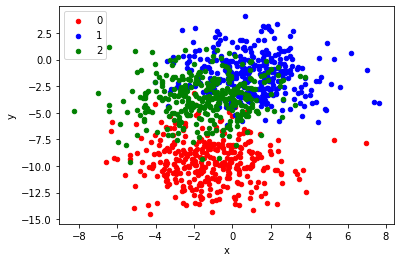

In [24]:
from matplotlib import pyplot
from pandas import DataFrame
# generate 2d classification dataset
#X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [25]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
y=np.reshape(y,(-1,1))

enc = OneHotEncoder()
y_new=enc.fit_transform(y).toarray()


In [26]:
print(y_new.shape)

(1000, 3)


In [35]:
import tensorflow.keras.utils as k
#y = k.to_categorical(y)
# split into train and test
n_train = 700
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y_new[:n_train], y_new[n_train:]
print(trainy.shape, testy.shape)

(700, 3) (300, 3)


In [28]:
y_new.shape

(1000, 3)

In [34]:
import tensorflow.keras.utils as k
#y = k.to_categorical(y)
# split into train and test
n_train = 700
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainy.shape, testy.shape)

(700, 1) (300, 1)


In [30]:
from tensorflow.keras import datasets, layers, models
model = models.Sequential()
model.add(layers.Dense(25, input_dim=2, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 25)                75        
                                                                 
 dense_3 (Dense)             (None, 3)                 78        
                                                                 
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________


In [36]:
trainy.shape

(700, 3)

In [37]:
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=0)

In [42]:
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.831, Test: 0.840


In [11]:
from os import makedirs
makedirs('models_EL1')

In [12]:

def fit_model(trainX, trainy):
	# define model
	model = models.Sequential()
	model.add(layers.Dense(25, input_dim=2, activation='relu'))
	model.add(layers.Dense(3, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit model
	model.fit(trainX, trainy, epochs=500, verbose=0)
	return model
 

n_members = 5
for i in range(n_members):
	# fit model#initialisation différente à chaque fois
	model = fit_model(trainX, trainy)
	# save model
	filename = 'models_EL1/model_' + str(i + 1) + '.h5'
	model.save(filename)
	print('>Saved %s' % filename)

>Saved models_EL1/model_1.h5
>Saved models_EL1/model_2.h5
>Saved models_EL1/model_3.h5
>Saved models_EL1/model_4.h5
>Saved models_EL1/model_5.h5


In [21]:
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'models_EL/model_' + str(i + 1) + '.h5'
		# load model from file
		model = models.load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models

In [22]:
all_models=load_all_models(5)
for model in all_models:
	#testy_enc = to_categorical(testy)
	_, acc = model.evaluate(testX, testy, verbose=0)
	print('Model Accuracy: %.3f' % acc)

>loaded models_EL/model_1.h5
>loaded models_EL/model_2.h5
>loaded models_EL/model_3.h5
>loaded models_EL/model_4.h5
>loaded models_EL/model_5.h5
Model Accuracy: 0.833
Model Accuracy: 0.843
Model Accuracy: 0.837
Model Accuracy: 0.847
Model Accuracy: 0.843


In [23]:
def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities] 1000,5,3
		if stackX is None:
			stackX = yhat
		else:
			stackX = np.dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities] (1000,5*3)
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

In [17]:
from sklearn.linear_model import LogisticRegression
def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    print(stackedX.shape)
    # fit standalone model
    model = LogisticRegression()
    model.fit(stackedX, inputy)
    return model

In [28]:
import tensorflow.keras.utils as k
#y = k.to_categorical(y)
# split into train and test
n_train = 700
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

(700, 2) (300, 2)


In [29]:
y.shape

(1000, 1)

In [19]:
# make a prediction with the stacked model
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat
 

model = fit_stacked_model(all_models, testX, testy)
# evaluate model on test set
yhat = stacked_prediction(all_models, model, testX)
acc = accuracy_score(testy, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

NameError: name 'all_models' is not defined